In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from dataprep.clean import clean_country

import dask.dataframe as dd

import dask.array as da

import dask.bag as db

In [47]:
# original site has a tool to query the data you want and it make the dataset more
# closer to what we need, so it would require 


In [48]:
# the csv is huge so i use dask
csv_file_path = "/home/amir/big_storage/datasets/IHME-GDB-Risk-Deaths.csv"
dask_df= dd.read_csv(csv_file_path)


In [49]:
df_global = dask_df[dask_df.location=="Global"]
dask_df = dask_df[dask_df.location!="Global"]
dask_df = clean_country(dask_df, 'location', output_format='alpha-3')
dask_df.head()
 

  0%|          | 0/172 [00:00<?, ?it/s]

Country Cleaning Report:
	9196380 values cleaned (100.0%)
Result contains 9196380 (100.0%) values in the correct format and 0 null values (0.0%)


,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,El Salvador,Female,35 to 39,Cardiovascular diseases,All risk factors,Number,2006,27.305953,32.514418,23.081097,SLV
1,Deaths,El Salvador,Both,35 to 39,Cardiovascular diseases,All risk factors,Number,2006,73.716938,89.396464,63.625658,SLV
2,Deaths,El Salvador,Male,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,28.985719,36.891028,23.719359,SLV
3,Deaths,El Salvador,Female,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,13.654947,16.259556,11.542215,SLV
4,Deaths,El Salvador,Both,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,20.471931,24.826292,17.669481,SLV


In [50]:
cause_list = [
    "Depressive disorders",
    "Cardiovascular diseases",
    "Chronic respiratory diseases",
    "Neurological disorders",
    "Tracheal, bronchus, and lung cancer",
    "Stomach cancer",
    "Pancreatic cancer",
    "Leukemia",
    "Esophageal cancer",
    "Larynx cancer",
    "Colon and rectum cancer",
    "Liver cancer",
    "Other non-communicable diseases",
]


In [65]:
df = dask_df[
    dask_df.cause.isin(cause_list)
    & (dask_df.metric == "Rate")
    & (dask_df.sex == "Both")
    & (dask_df.year >= 2010)
    & (dask_df.rei == "Air pollution")
]
df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
27781,Deaths,Ethiopia,Both,85 plus,Other non-communicable diseases,Air pollution,Rate,2012,0.000000,0.000000,0.000000,ETH
28657,Deaths,Belgium,Both,25 to 29,Chronic respiratory diseases,Air pollution,Rate,2012,0.022587,0.033853,0.013638,BEL
28663,Deaths,Belgium,Both,30 to 34,Chronic respiratory diseases,Air pollution,Rate,2012,0.037161,0.056878,0.022765,BEL
28669,Deaths,Belgium,Both,35 to 39,Chronic respiratory diseases,Air pollution,Rate,2012,0.070377,0.104083,0.045132,BEL
28675,Deaths,Belgium,Both,40 to 44,Chronic respiratory diseases,Air pollution,Rate,2012,0.189128,0.267197,0.123217,BEL


In [66]:
# let see which country suffer the most from this disease in recent years
df.age.unique()

array(['85 plus', '25 to 29', '30 to 34', '35 to 39', '40 to 44',
       '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69',
       '70 to 74', '75 to 79', '80 to 84'], dtype=object)

In [26]:
total_by_country = df[(df.sex=="Both") & (df.year == 2017)].groupby(["location", "location_clean"]).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_fisr=("val", "min"),
    val_max=("val", "max"),

).reset_index()

total_by_country.head()
# .sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

,location,location_clean,val_sum,val_mean,val_fisr,val_max
0,Afghanistan,AFG,10173.691086,260.863874,0.144592,2299.081096
1,Albania,ALB,3443.809665,88.302812,0.036182,1135.291591
2,Algeria,DZA,4427.828059,113.534053,0.035860,1892.843703
3,Argentina,ARG,1049.951235,26.921827,0.043376,241.701123
4,Armenia,ARM,4516.643019,115.811359,0.064922,1276.720792


In [67]:
world = df.groupby(['location',"location_clean", 'age', 'year']).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_first=("val", "min"),
    val_max=("val", "max"),
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int')).reset_index()
world.head()

,location,location_clean,age,year,val_sum,val_mean,val_first,val_max
0,Afghanistan,AFG,25 to 29,2010,17.236644,5.745548,0.150468,15.351325
1,Pakistan,PAK,25 to 29,2012,10.977146,3.659049,0.132684,10.323202
2,Pakistan,PAK,25 to 29,2013,11.183041,3.727680,0.134844,10.523817
3,Pakistan,PAK,25 to 29,2014,11.309370,3.769790,0.136738,10.651012
4,Pakistan,PAK,25 to 29,2015,11.317433,3.772478,0.136471,10.670210


In [68]:
china = df[(df.location=='China')].groupby(["location", "location_clean", "age"]).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_first=("val", "min"),
    val_max=("val", "max"),
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int')).reset_index()
china.head(40)

,location,location_clean,age,val_sum,val_mean,val_first,val_max
0,China,CHN,25 to 29,42.478308,1.415944,0.112679,4.137341
1,China,CHN,30 to 34,79.238005,2.641267,0.231931,7.699838
2,China,CHN,35 to 39,135.269191,4.508973,0.418678,12.343705
3,China,CHN,40 to 44,258.560592,8.618686,0.931691,23.996185
4,China,CHN,45 to 49,435.028397,14.500947,1.725389,40.329065
5,China,CHN,50 to 54,695.544807,23.184827,3.950061,58.851724
6,China,CHN,55 to 59,1168.495702,38.949857,8.369452,93.436351
7,China,CHN,60 to 64,2091.307910,69.710264,19.819554,168.621468
8,China,CHN,65 to 69,3532.899597,117.763320,44.151035,267.342121
9,China,CHN,70 to 74,6518.397990,217.279933,77.042370,464.698299


In [70]:
# create lables for chart
x_axis_label = [i.replace(' to ', '-') for i in world.age.unique()]
print(x_axis_label)

['25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 plus']


Text(0.5, 0, 'Age')

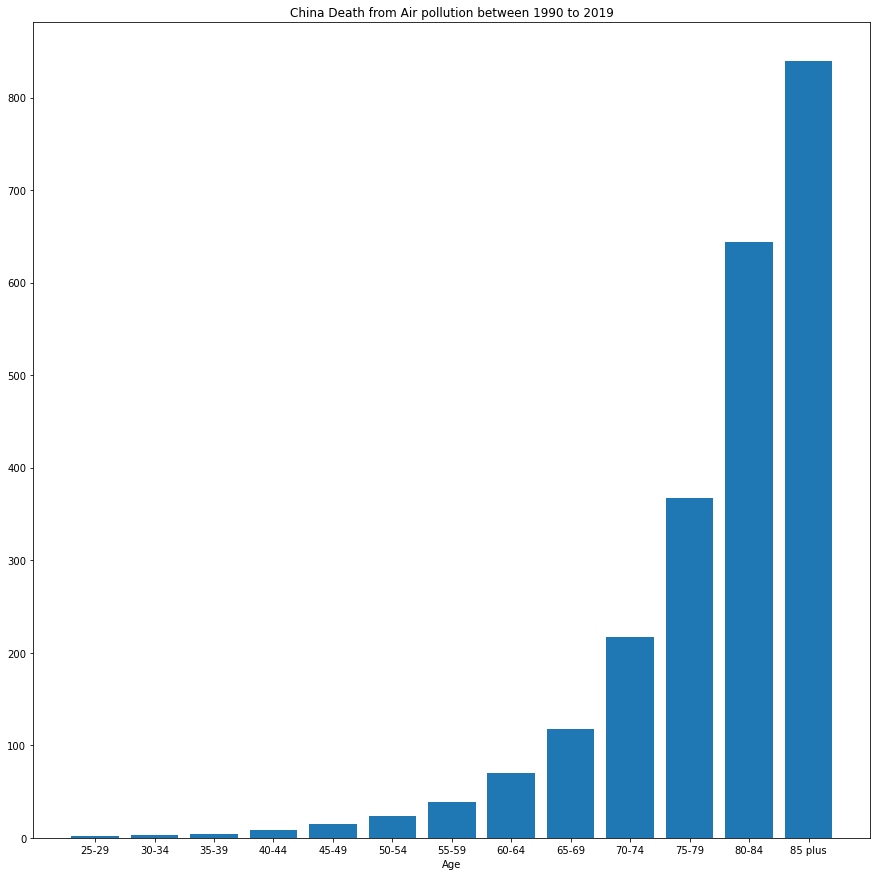

In [72]:
# plot for one country
fig, ax = plt.subplots(figsize=(15, 15))
ax.bar(x=x_axis_label, height=china.val_mean.values)
ax.set_title("China Death from Air pollution between 2010 to 2019")
ax.set_xlabel("Age")

In [90]:
l = {"Qatar": "QAT", "India": "IND", "USA": "USA", "Findland": "FIN", "China": "CHN", "Iran": "IRN", "Afghanestan": "AFG"}


In [91]:
fig_data = []
for name, code in l.items():

    country_states = (
        df[(df.location_clean == code)]
        .groupby(["location", "location_clean", "age"])
        .agg(
            val_sum=("val", "sum"),
            val_mean=("val", "mean"),
            val_first=("val", "min"),
            val_max=("val", "max"),
        )
        .sort_values(
            by="age", key=lambda x: x.str.split(" ", expand=True)[0].astype("int")
        )
        .reset_index()
    )
    fig_data.append(go.Bar(name=name, x=x_axis_label, y=country_states.val_mean))
# Change the bar mode
fig = go.Figure(data=fig_data)
fig.update_layout(
    barmode="group",
    xaxis_title="Country",
    yaxis_title="Risk Mean (2010-2015)",
    legend_title="Risk Factor",
    title="Countries Date Rate From Air Pollution Compare",
)
fig.show()


<BarContainer object of 18 artists>

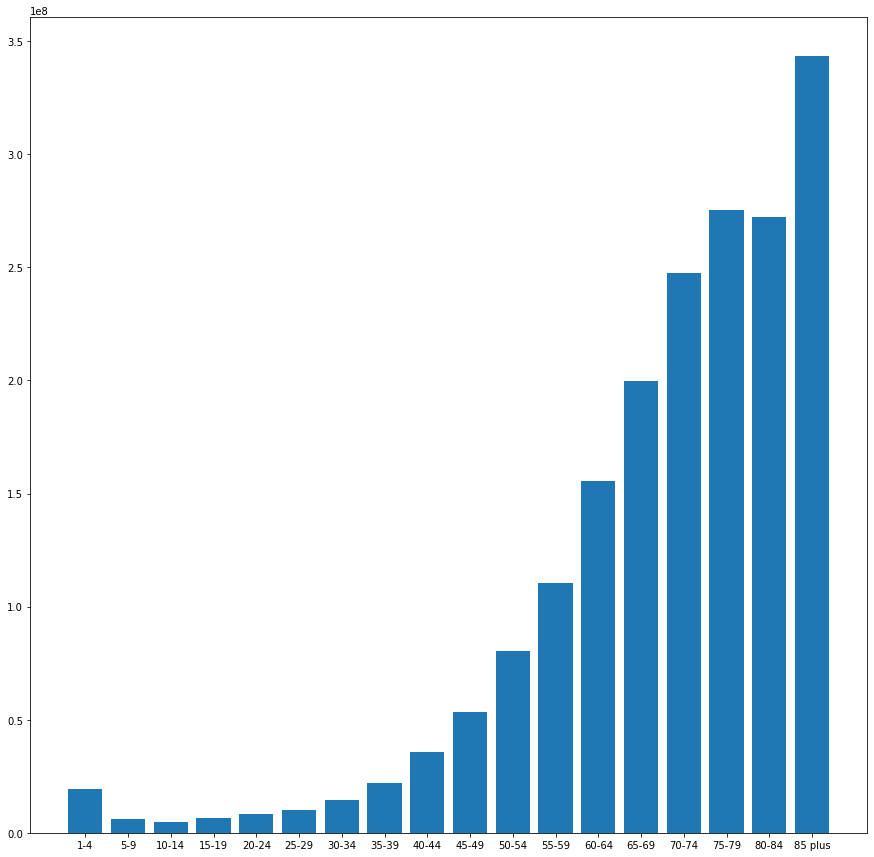

In [122]:
fig, ax = plt.subplots(figsize=(15, 15)kk)
x_axis_label = [i[1].replace(' to ', '-') for i in china.index]
ax.bar(x=x_axis_label, height=age_death_rate.val.values)

In [34]:
cdf

,measure,location,sex,age,cause,metric,year,val,upper,lower
4,Deaths,Gabon,Male,1 to 4,Cardiovascular diseases,Number,2016,1.307133,2.660127,0.520400
5,Deaths,Gabon,Female,1 to 4,Cardiovascular diseases,Number,2016,0.506277,1.594778,0.177413
6,Deaths,Gabon,Both,1 to 4,Cardiovascular diseases,Number,2016,1.813410,4.013179,0.748420
7,Deaths,Gabon,Male,5 to 9,Cardiovascular diseases,Number,2016,0.883534,1.491956,0.494747
8,Deaths,Gabon,Female,5 to 9,Cardiovascular diseases,Number,2016,0.502440,0.915741,0.289085
...,...,...,...,...,...,...,...,...,...,...
4630423,Deaths,Argentina,Female,80 to 84,Stroke,Number,2006,2386.710574,2690.004918,2051.770217
4630424,Deaths,Argentina,Both,80 to 84,Stroke,Number,2006,4117.693988,4646.843314,3569.852176
4630425,Deaths,Argentina,Male,85 plus,Stroke,Number,2006,1701.973332,1915.251968,1449.030823
4630426,Deaths,Argentina,Female,85 plus,Stroke,Number,2006,3811.848856,4292.646199,3125.849003


In [35]:
each_year = cdf[cdf.sex=="Both"].groupby(['age', 'year', "location"]).agg(
    {'val': 'sum',
    'upper': 'sum',
    'lower': 'sum'}
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

In [48]:
pd.DataFrame(each_year.to_records())

,age,year,location,val,upper,lower
0,1 to 4,1990,Afghanistan,123.802161,251.569842,45.748402
1,1 to 4,2010,Argentina,47.757941,59.538155,38.132899
2,1 to 4,2010,Algeria,112.904407,185.349133,63.360739
3,1 to 4,2010,Albania,18.931777,28.403113,10.330312
4,1 to 4,2010,Afghanistan,95.790463,186.120422,47.527911
...,...,...,...,...,...,...
85315,85 plus,1999,Viet Nam,35701.561231,42351.176110,28336.014076
85316,85 plus,1999,Venezuela (Bolivarian Republic of),7595.470933,8471.430913,6020.432246
85317,85 plus,1999,Uzbekistan,17370.999785,18259.860352,15613.066091
85318,85 plus,1999,United States of America,402665.507811,438028.946860,334826.310303


In [37]:
each_year.query("year==2019")

val         upper         lower
age     year location                                             
1 to 4  2019 Indonesia      212.012270    339.536022    149.955315
             India          969.902351   1313.288294    718.470924
             Hungary          1.380377      1.899329      0.874539
             Honduras        18.208949     34.032755      7.379660
             Haiti          211.209118    366.792208     79.631302
...                                ...           ...           ...
85 plus 2019 Algeria      32139.094540  36959.176300  27104.176321
             Albania       5382.987286   6600.857457   4160.189293
             Afghanistan   6636.642420   7847.148201   5045.227029
             Zambia        2359.632430   2837.981251   1855.141774
             Zimbabwe      2499.231806   3167.141289   1950.361929

[2844 rows x 3 columns]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

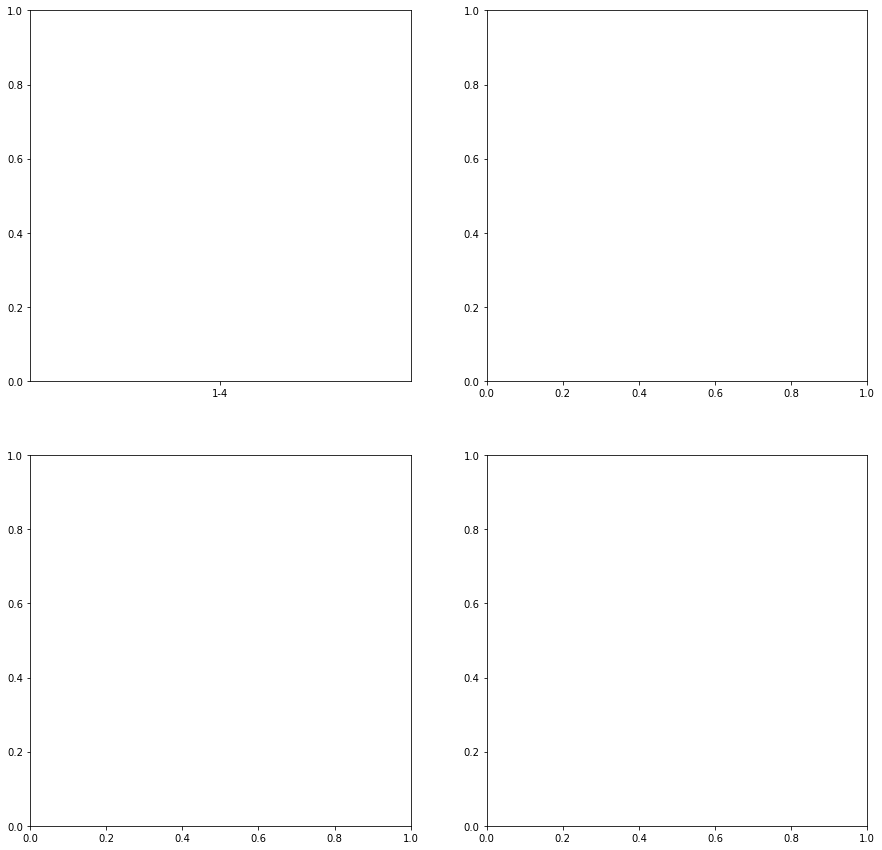

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for i in range(2):
    for j in range(2):
        axs[i, j].bar(x=x_axis_label, height=each_year.query(f"year==20{i:02d}").val.values)
# axs[1].bar(x=x_axis_label, height=each_year.query("year==2019").val.values)
plt.show()

2001


In [97]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


In [14]:
total_by_country.head()

,location,val,upper,lower
0,Afghanistan,2.046121e+06,2.638194e+06,1.521819e+06
1,Albania,3.898698e+05,4.484619e+05,3.305901e+05
2,Algeria,2.666153e+06,3.250194e+06,2.146378e+06
3,Argentina,3.620805e+06,3.898845e+06,3.263956e+06
4,Armenia,4.838629e+05,5.152785e+05,4.461976e+05


In [51]:
# add country iso codes
total_by_country = clean_country(total_by_country, 'location', output_format='alpha-3')


  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	157 values cleaned (100.0%)
Result contains 157 (100.0%) values in the correct format and 0 null values (0.0%)


In [93]:
total_by_country.describe()

,val,upper,lower,nn
count,1.570000e+02,1.570000e+02,1.570000e+02,157.000000
mean,4.648683e+06,5.515382e+06,3.914767e+06,46.486824
std,1.735093e+07,2.009171e+07,1.486240e+07,173.509335
min,2.731631e+04,3.629686e+04,2.055393e+04,0.273160
25%,4.033722e+05,5.237928e+05,3.049161e+05,4.033720
50%,9.322235e+05,1.243332e+06,7.193531e+05,9.322230
75%,2.801925e+06,3.275085e+06,2.232634e+06,28.019250
max,1.877723e+08,2.182027e+08,1.602508e+08,1877.722510


In [ ]:
# i really like to do the geomap but plotly don't show the map color correctly
# so let do and scatter!

In [106]:
fig = px.choropleth(
    total_by_country,
    locations="location_clean",
    color="val",
    hover_name="location",
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# plotly.offline.plot(fig,filename='world.html')
fig.show()
